In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
from scipy.stats import norm
from scipy.special import factorial
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

plt.style.use('seaborn')

In [2]:
def BS_call(sigma, S, K, r, T):
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * T ** 0.5)
    d2 = (np.log(S / K) + (r - sigma ** 2 / 2) * T) / (sigma * T ** 0.5)
    c = S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)
    return c

In [3]:
def call_delta(sigma, S, K, r, T):
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * T ** 0.5)
    return norm.cdf(d1)

In [4]:
def put_delta(sigma, S, K, r, T):
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * T ** 0.5)
    return norm.cdf(d1) - 1

In [5]:
def get_call_price(S0, r, T, lam, sigma, v, delta, K_list, max_n=1000, tol=0.0000000001):
    n = 0
    res = 0
    for i in range(max_n):
        k = np.exp(v + delta ** 2 / 2) - 1
        lam2 = lam * (1 + k)
        a = np.exp(-lam2 * T) * (lam2 * T) ** n / factorial(n, exact=True)
        if a < tol:
            return res
            break
        sigma_n = np.sqrt(sigma ** 2 + n / T * delta ** 2)
        r_n = r - lam * k + (v + delta ** 2 / 2) * n / T
        c = BS_call(sigma_n, S0, K_list, r_n, T)
        res += a * c
        n += 1
    if a >= tol:
        return res

In [6]:
def get_implied_vol(sigma, *args):
    S, K, r, T, c = args
    return BS_call(sigma, S, K, r, T) - c

In [7]:
# def obj2(x, *args):
#     sigma, v, delta = x[0], x[1], x[2]
#     S0, r, lam, T, K_list, spread, implied_vol = args
    
#     c = get_call_price(S0, r, T, lam, sigma, v, delta, K_list)
#     implied_vol2 = fsolve(get_implied_vol, np.ones(len(K_list)), args=(S0, K_list, r, T, c))
#     err = sum((implied_vol2 - implied_vol) ** 2 / spread)
#     return err

In [8]:
def get_RR_BF(implied_vol, S, K_list, r, T):
    delta_c = call_delta(implied_vol, S, K_list, r, T)
    delta_p = put_delta(implied_vol, S, K_list, r, T)
    sigma_0 = implied_vol[np.where(abs(K_list - S) == np.min(abs(K_list - S)))[0][0]]
    condition = (0.25 <= delta_c) & (delta_p <= 0.75-1)
    if len(implied_vol[condition])==0:
        RR = 20
        BF = 20
    else:
        sigma_plus, sigma_minus = implied_vol[condition][-1], implied_vol[condition][0]
    
        RR = sigma_plus - sigma_minus
        BF = (sigma_plus + sigma_minus) / 2 - sigma_0
    return RR, BF, sigma_0

In [9]:
def obj(x, *args):
    sigma, v, delta = x[0], x[1], x[2]
    S0, r, lam, T, K_list, RR, BF, sigma_0 = args
    
    c = get_call_price(S0, r, T, lam, sigma, v, delta, K_list)
    implied_vol = fsolve(get_implied_vol, np.ones(len(K_list)), args=(S0, K_list, r, T, c))
    
    RR2, BF2, sigma_02 = get_RR_BF(implied_vol, S0, K_list, r, T)
    
    err = ((RR-RR2) **2 +  (BF-BF2) ** 2 / 4 + (sigma_0-sigma_02) ** 2)/3
    return err

In [10]:
def default_prob(V, r, T, lam, sigma, v, delta, D, max_n=10000, tol=0.0000001):
    n = 0
    res = 0
    k = np.exp(v + delta ** 2 / 2) - 1
    for i in range(max_n):
        a = np.exp(-lam * T) * (lam * T) ** n / factorial(n, exact=True)
        if a < tol:
            return res
            break
        sigma_n = np.sqrt(sigma ** 2 + n / T * delta ** 2)
        r_n = r - lam * k + (v + delta ** 2 / 2) * n / T
        d_n = (np.log(V/D)+(r_n+sigma_n**2/2)*T)/(sigma_n*np.sqrt(T))
        c = norm.cdf(-d_n+sigma_n*np.sqrt(T))
        res += a * c
        n += 1
    if a >= tol:
        return res

In [53]:
def delta_V(V, r, T, lam, sigma, v, delta, D, max_n=10000, tol=0.0000001):
    n = 0
    res = 0
    k = np.exp(v + delta ** 2 / 2) - 1
    for i in range(max_n):
            k = np.exp(v + delta ** 2 / 2) - 1
            lam2 = lam * (1 + k)
            a = np.exp(-lam2 * T) * (lam2 * T) ** n / factorial(n, exact=True)
            if a < tol:
                return res
                break
            sigma_n = np.sqrt(sigma ** 2 + n / T * delta ** 2)
            r_n = r - lam * k + (v + delta ** 2 / 2) * n / T
            d_n = (np.log(V/D)+(r_n+sigma_n**2/2)*T)/(sigma_n*np.sqrt(T))
            c = norm.cdf(d_n)
            res += a * c
            n += 1
    if a >= tol:
        return res

In [12]:
def solve_V_sigma(x, *args):
    V, sigma_V, n = x[0], x[1], x[2]
    paramlist, lam, S0, r, T, D = args
    sigma, v, delta = paramlist[0], n * paramlist[1], n * paramlist[2]
    S_mod = get_call_price(V, r, T, lam, sigma_V, v, delta, D)
    d1 = (np.log(V / D) + (r + sigma_V ** 2 / 2) * T) / (sigma_V * T ** 0.5)
    sigma_mod = delta_V(V, r, T, lam, sigma, v, delta, D) * V * sigma_V / S0
    err = np.mean((sigma_mod/sigma-1)**2 + (S_mod/S0-1)**2)
    return err

In [13]:
def solve_parameters(x, *args):
    sigma_VV, n = x[0], x[1]
    paramlist, V, sigma_V, r, T, lam, D, S0 = args
    nu_V, delta_V = n * paramlist[1], n * paramlist[2]
    S_mod = get_call_price(V, r, T, lam, sigma_VV, nu_V, delta_V, D)
    sigma_mod = fsolve(get_implied_vol, 0.05, args=(V, D, r, T, S_mod))
    err = (sigma_mod/sigma_V-1)**2 + (S_mod/S0-1)**2
    
    return err

In [14]:
def get_paramlist(lam, *args):
    S0, r, T, K_list, RR, BF, sigma_0, D = args
    args = (S0, r, lam, T, K_list, RR, BF, sigma_0)
    x0 = np.array([0.1, -0.1, 0.1])
    bnds = ((0, 1), (None, None), (0, None))
    res = minimize(obj, x0, args=args, method='SLSQP', bounds=bnds, tol=0.0000001)
    return res.x

In [15]:
def get_V_sigma(lam, *args):
    paramlist, S0, r, T, K_list, RR, BF, D = args
    sigma = paramlist[0]
    V_0 = S0 + D * np.exp(-r*T)
    sigma_V_0 = sigma * S0 / V_0
    x0 = np.array([V_0, sigma_V_0, 1])
    args = (paramlist, lam, S0, r, T, D)
    bnds = ((None, None),(0, 0.25), (0, 1))
    res = minimize(solve_V_sigma, x0, args=args, method='SLSQP', bounds=bnds, tol=0.000001)
    return res.x[0], res.x[1], res.x[2]

In [16]:
def get_P_default(lam, *args):
    paramlist, S0, r, T, K_list, RR, BF, D = args
    V, sigma_V, n = get_V_sigma(lam, paramlist, S0, r, T, K_list, RR, BF, D)
    v, delta = n * paramlist[1], n * paramlist[2]
    
    return default_prob(V, r, 1, lam, sigma_V, v, delta, D)

In [17]:
# def obj2(lam, *args):
#     paramlist,S0, r, T, K_list, RR, BF, sigma_0, D = args
#     p = get_P_default(lam, paramlist, S0, r, T, K_list, RR, BF, sigma_0, D)
#     return (p - 0.001) ** 2

In [18]:
# def get_lambda(lam, *args):
#     paramlist, S0, r, T, K_list, RR, BF, sigma_0, D = args
#     args = (paramlist, S0, r, T, K_list, RR, BF, sigma_0, D)
#     res = minimize(obj2, lam, args=args, method='SLSQP', tol=0.000000001)
#     return res.x

In [19]:
def get_lam(lam, *args):
    paramlist, S0, r, T, K_list, RR, BF, D, p_default = args
    return (get_P_default(lam, paramlist, S0, r, T, K_list, RR, BF, D)/p_default - 1)**2

In [20]:
lam = 5 / 3
S0 = 227.009995
D = 227.009995/0.66
K_list = np.array([227.009995 + i for i in range(-60, 61, 1)])
r = 0.01
T = 209/365
sigma_0 = 0.223952
sigma_plus = 0.207325
sigma_minus = 0.254359
K_plus = 255
K_minus = 205
RR = sigma_plus - sigma_minus
BF = (sigma_plus + sigma_minus)/2 - sigma_0

# lam = 1
# tol = 1
# max_inter = 100
# while tol >= 0.000001 and max_inter > 0:
#     paramlist = get_paramlist(lam, S0, r, T, K_list, RR, BF, sigma_0, D)
#     lam_new = fsolve(get_lam, lam, args=(paramlist, S0, r, T, K_list, RR, BF, D, 0.0048))
#     tol = abs(lam_new - lam)
#     lam = lam_new
#     max_inter -= 1
#     paramlist_new = get_paramlist(lam, S0, r, T, K_list, RR, BF, sigma_0, D)
#     print(get_P_default(lam, paramlist, S0, r, T, K_list, RR, BF, D), get_P_default(lam, paramlist_new, 227.009995, r, T, K_list, RR, BF, D))

lam_chose = np.linspace(0.1,0.2,100)
p_default_1 = np.zeros(100)
for i in range(100):
    paramlist = get_paramlist(lam_chose[i], S0, r, T, K_list, RR, BF, sigma_0, D)
    V_i, sigma_V_i, n_i = get_V_sigma(lam_chose[i], paramlist, S0, r, T, K_list, RR, BF, D)
    p_default_1[i] = abs(default_prob(V_i, r, 1, lam_chose[i], sigma_V_i, n_i*paramlist[1], n_i*paramlist[2], D)-0.0048)
    print(i, default_prob(V_i, r, 1, lam_chose[i], sigma_V_i, n_i*paramlist[1], n_i*paramlist[2], D))
index = np.where(p_default_1 == np.min(p_default_1))[0][0]
paramlist = get_paramlist(lam_chose[index], S0, r, T, K_list, RR, BF, sigma_0, D)
V, sigma_V, n = get_V_sigma(lam_chose[index], paramlist, 227.009995, r, T, K_list, RR, BF, D)


0 0.0010208228533435879
1 0.005537842936278738
2 0.009249736634771253
3 0.013392046595295849
4 0.013969716050891656
5 0.014711101451584645
6 0.010665531256011196
7 0.011045216405538938
8 0.01132993588315186
9 0.011545607392787632
10 0.011728471065907353
11 0.011868192011179918
12 0.011989110655010163
13 0.012082052019016461
14 0.01215523159244937
15 0.01221254011625504
16 0.012258662430205897
17 0.012296196476442254
18 0.012332445750207054
19 0.012364685026017005
20 0.012393658847208907
21 0.01241595932291625
22 0.01246692665817646
23 0.012493653905340713
24 0.012510896384632736
25 0.012528188660748125
26 0.01254051019925514
27 0.012547448983410639
28 0.012549741459486698
29 0.012543370119761154
30 0.01255681256382267
31 0.012542423565022394
32 0.01252294139577531
33 0.012499414722870097
34 0.012471755705863652
35 0.012440855222677199
36 0.012407483559361799
37 0.012372207733305439
38 0.012321814207791475
39 0.012281383999982475
40 0.012238385255209957
41 0.012180661400496484
42 0.0121

In [21]:
S0 = 227.009995
D = 227.009995/0.66
K_list = np.array([227.009995 + i for i in range(-60, 61, 1)])
r = 0.01
T = 209/365
sigma_0 = 0.223952
sigma_plus = 0.207325
sigma_minus = 0.254359
K_plus = 255
K_minus = 205
RR = sigma_plus - sigma_minus
BF = (sigma_plus + sigma_minus)/2 - sigma_0

lam_original = 5/3
paramlist_original = np.array([0.11916426, -0.11249276,  0.11583683])
V, sigma_V, n = get_V_sigma(lam_original, paramlist_original, 227.009995, r, T, K_list, RR, BF, D)

In [22]:
V, sigma_V, n

(569.0006677392719, 0.0479424778674135, 0.9999989490593603)

In [23]:
default_prob(V, r, 1, lam_original, sigma_V, n*paramlist_original[1], n*paramlist_original[2], D)

0.028717677771640263

In [24]:
lam = lam_chose[index]

In [25]:
lam

0.10101010101010102

In [26]:
paramlist=get_paramlist(lam, S0, r, T, K_list, RR, BF, sigma_0, D)

In [27]:
paramlist

array([ 0.17777603, -0.79625213,  0.58006138])

In [28]:
V, sigma_V, n = get_V_sigma(lam, paramlist, 227.009995, r, T, K_list, RR, BF, D)

In [29]:
sigma_V, n

(0.07112519548244985, 0.2793070479457188)

In [30]:
0.2793070479457188* np.array([-0.79625213,  0.58006138])

array([-0.22239883,  0.16201523])

In [31]:
V

568.906420984315

In [32]:
default_prob(V, r, 1, lam, sigma_V, n*paramlist[1], n*paramlist[2], D)

0.005537842936278738

In [33]:
get_call_price(V, r, T, lam, sigma_V, n*paramlist[1], n*paramlist[2], D)

226.99733436439348

Text(0, 0.5, 'implied_vol')

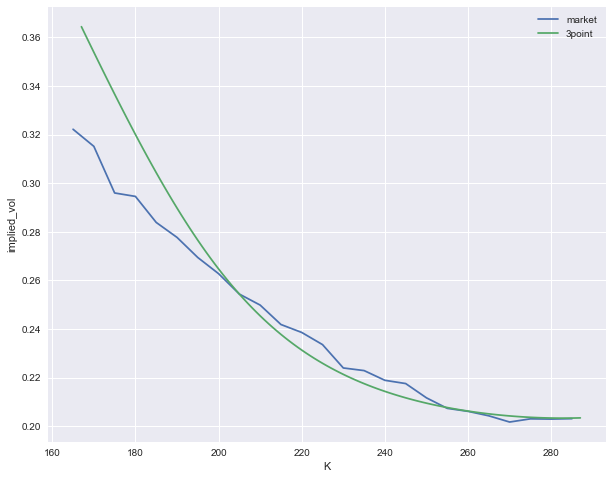

In [34]:
sigma, v, delta = 0.17777603, -0.79625213,  0.58006138
c1 = get_call_price(S0, r, T, lam, sigma, v, delta, K_list)
implied_vol1 = fsolve(get_implied_vol, np.ones(len(K_list)), args=(S0, K_list, r, T, c1))
K_list2 = np.array([165 + i*5 for i in range(0, 25)])
implied_vol = np.array([0.322205925470394, 0.315172864592547, 0.295983260468313,
       0.29456929414918104, 0.28385952743335, 0.277702188077411,
       0.269420801690042, 0.26276526736628003, 0.254359095349089,
       0.24983323379033098, 0.241837325920689, 0.238566784782187,
       0.233564289395348, 0.22395179822024902, 0.22287047898573,
       0.218873246430956, 0.21753245481342098, 0.211653563144179,
       0.207325144289639, 0.20609309346663002, 0.20425061661487,
       0.201694827304974, 0.20300745434908, 0.202914053761969,
       0.203084014482271])

plt.figure(figsize=(10,8))
plt.plot(K_list2,implied_vol)
plt.plot(K_list,implied_vol1)
#plt.plot(K_list2,implied_vol2)
plt.legend(['market', '3point'])
plt.xlabel("K")
plt.ylabel("implied_vol")

# Backtest

In [74]:
bkdata = pd.read_excel("Desktop/772backtestdata.xlsx")
bkdata = bkdata.iloc[:,:6]
bkdata.columns = ['Strikes', 'Tickers', 'Bids', 'Asks', 'Last', 'Implied_Vol']

bkdata['Price'] = (bkdata['Bids'] + bkdata['Asks'])/2

bkdata = bkdata.dropna(axis = 'rows')

stock_default = pd.read_excel('Desktop/BRKBstockprice with default prob.xlsx')


S = np.array(stock_default['Last Price.1'][2:16])


def all_data(bkdata, S):
    T_total = []
    sigma_0 = []
    K_plus = []
    K_minus = []
    RR = []
    BF = []
    for i in range(len(S)):
        S_input = S[i]
        T = (i*7+217)/365 
        T_total += [T]
        bkdata_i = bkdata.iloc[int(i*25):int((i+1)*25)]
        get_d = (np.log(S_input/np.array(bkdata_i['Strikes'],dtype=float))+(r + (bkdata_i['Implied_Vol']/100) ** 2/2) * T)/((bkdata_i['Implied_Vol']/100) * np.sqrt(T))
        Delta = norm.cdf(np.array(get_d, dtype=float))
        close_plus = min(abs(Delta - 0.25))
        close_minus = min(abs(Delta - 0.75))
        close_0 = min(abs(Delta - 0.5))
        index_plus = np.where(abs(Delta - 0.25) == close_plus)[0][0]
        index_minus = np.where(abs(Delta - 0.75) == close_minus)[0][0]
        index_0 = np.where(abs(Delta - 0.5) == close_0)[0][0]
        K_plus += [bkdata_i['Strikes'].iloc[index_plus]]
        K_minus += [bkdata_i['Strikes'].iloc[index_minus]]
        sigma_plus = bkdata_i['Implied_Vol'].iloc[index_plus]
        sigma_minus = bkdata_i['Implied_Vol'].iloc[index_minus]
        sigma_0_i = bkdata_i['Implied_Vol'].iloc[index_0]
        sigma_0 += [sigma_0_i]
        RR += [sigma_plus - sigma_minus]
        BF += [(sigma_plus + sigma_minus)/2 - sigma_0_i]
    
    return T_total, np.array(sigma_0)/100, K_plus, K_minus, np.array(RR)/100, np.array(BF)/100

r = 0.01
T_total, sigma_0_total, K_plus_total, K_minus_total, RR_total, BF_total = all_data(bkdata, S)

p_default_total = np.array([0.005, 0.0052, 0.006, 0.005, 0.0054, 0.005, 0.006, 0.0066, 0.0052, 0.0056, 0.0058, 0.0054, 0.0054, 0.0056])

In [59]:
V = []
paramlist_total = []
n = []
sigma_V = []
lam_total = []
S_mod = np.zeros(14)
p_default_mod = np.zeros(14)

for i in range(14):  
    lam = 5 / 3
    S0 = float(S[i])
    D = S[i]/0.66
    K_list = np.array([S[i] + m for m in range(-60, 61, 1)])
    r = 0.01
    T = float(T_total[i])
    sigma_0 = float(sigma_0_total[i])
    K_plus = float(K_plus_total[i])
    K_minus = float(K_minus_total[i])
    RR = float(RR_total[i])
    BF = float(BF_total[i])
    p_default = p_default_total[i]
 
    lam_chose = np.linspace(0.095, 0.105, 20)
    p_default_1 = np.zeros(20)
    for j in range(20):
        paramlist_j = get_paramlist(lam_chose[j], S0, r, T, K_list, RR, BF, sigma_0, D)
        V_j, sigma_V_j, n_j = get_V_sigma(lam_chose[j], paramlist_j, S0, r, T, K_list, RR, BF, D)
        p_default_1[j] = abs(default_prob(V_j, r, 1, lam_chose[j], sigma_V_j, n_j*paramlist_j[1], n_j*paramlist_j[2], D)-p_default)
        #print(j, default_prob(V_j, r, 1, lam_chose[j], sigma_V_j, n_j*paramlist_j[1], n_j*paramlist_j[2], D))
    index = np.where(p_default_1 == np.min(p_default_1))[0][0]
    
    paramlist_i = get_paramlist(lam_chose[index], S0, r, T, K_list, RR, BF, sigma_0, D)
    V_i, sigma_V_i, n_i = get_V_sigma(lam_chose[index], paramlist_i, S[i], r, T, K_list, RR, BF, D)
    S_mod[i] = get_call_price(V_i, 0.01, T, lam_chose[index], sigma_V_i, paramlist_i[1]*n_i, paramlist_i[2]*n_i, D)
    p_default_mod[i] = get_P_default(lam_chose[index], paramlist_i, S[i], r, T, K_list, RR, BF, D)
    lam_total += [lam_chose[index]]
    V += [V_i]
    sigma_V += [sigma_V_i]
    n += [n_i]
    paramlist_total += [paramlist_i]

In [60]:
lam_total = np.array([lam_total[i] for i in range(14)])
lam_total = np.concatenate((np.array([0.10101010101010102]),lam_total), axis = None)
V = np.array([568.906420984315]+V)
sigma_S = np.array([0.17777603] + [paramlist_total[i][0] for i in range(len(S))])
nu_S = np.array([-0.79625213] + [paramlist_total[i][1] for i in range(len(S))])
delta_S = np.array([0.58006138] + [paramlist_total[i][2] for i in range(len(S))])
factor = np.array([0.2793070479457188] + n)
sigma_V = np.array([0.07112519548244985] + sigma_V)
S = np.append(227.009995, S)
S_mod = np.append(226.99733436439348, S_mod)
p_default_mod = np.append(0.005537842936278738, p_default_mod)
p_default_total = np.append(0.0048, p_default_total)
nu_V = factor * nu_S
Delta_V = factor * delta_S

In [61]:
date = ['2020-11-20', '2020-11-13', '2020-11-06', '2020-10-30', '2020-10-23', '2020-10-16', '2020-10-09', '2020-10-02', 
       '2020-09-25', '2020-09-18', '2020-09-11', '2020-09-04', '2020-08-28', '2020-08-21', '2020-08-14']

In [62]:
Back_Test_Parameters = pd.DataFrame(lam_total, index = date, columns = ['intensity'])
Back_Test_Parameters['stock price'] = S
Back_Test_Parameters['estimate_stock_price'] = S_mod
Back_Test_Parameters['asset value'] = V
Back_Test_Parameters['Stock Sigma'] = sigma_S
Back_Test_Parameters['Stock nu'] = nu_S
Back_Test_Parameters['Stock delta'] = delta_S
Back_Test_Parameters['Asset nu'] = nu_V
Back_Test_Parameters['Asset delta'] = Delta_V
Back_Test_Parameters['Default_prob_market'] = p_default_total
Back_Test_Parameters['Default_prob_estimate'] = p_default_mod
Back_Test_Parameters['Asste Sigma'] = sigma_V
Back_Test_Parameters['Factor'] = np.append(0.2793070479457188, n)

In [68]:
def Delta_S(S, r, T, lam, sigma, v, delta, K, max_n=10000, tol=0.0000001):
    n = 0
    res = 0
    k = np.exp(v + delta ** 2 / 2) - 1
    for i in range(max_n):
            k = np.exp(v + delta ** 2 / 2) - 1
            lam2 = lam * (1 + k)
            a = np.exp(-lam2 * T) * (lam2 * T) ** n / factorial(n, exact=True)
            if a < tol:
                return res
                break
            sigma_n = np.sqrt(sigma ** 2 + n / T * delta ** 2)
            r_n = r - lam * k + (v + delta ** 2 / 2) * n / T
            d_n = (np.log(S/K)+(r_n+sigma_n**2/2)*T)/(sigma_n*np.sqrt(T))
            c = norm.cdf(d_n)
            res += a * c
            n += 1
    if a >= tol:
        return res

In [69]:
ATM_strike = [210, 210, 220, 220, 220, 220, 210, 210, 210, 210, 210, 200, 210, 230]
C_price_start = [17.5, 14.95, 16.3, 17.48, 16.75, 16.6, 17.05, 19.39, 20.1, 17.25, 17.5, 17.725, 15, 14.5]
C_price_end = [27.25, 27.25, 20.65, 20.65, 20.65, 20.65, 27.25, 27.25, 27.25, 27.25, 27.25, 34.7, 27.25, 14.65]
Delta_hedge_jump_diffusion = np.zeros(14)
for i in range(14):
    time = (14-i)*7/365
    S_start = S[-i-1]
    S_end = S[0]
    sigma_S_start = sigma_S[-i-1]
    nu_S_start = nu_S[-i-1]
    delta_S_start = delta_S[-i-1]
    TTM = T_total[-i-1]
    lam_start = lam_total[-i-1]
    K = ATM_strike[i]
    call_start = C_price_start[i]
    call_end = C_price_end[i]
    Delta = Delta_S(S_start,0.01, TTM, lam_start, sigma_S_start, nu_S_start, delta_S_start, K)
    P_and_L = (Delta*(S_end - S_start) - (call_end - call_start))
    Delta_hedge_jump_diffusion[i] = P_and_L

In [70]:
Delta_hedge_jump_diffusion

array([ 0.80846114, -0.56773019,  0.80591522,  1.95364227,  1.63411178,
        1.33643695,  0.3379161 ,  2.60593839,  0.48283733, -0.34485138,
       -0.49082436, -1.0772011 , -1.1552863 , -0.38830092])

In [71]:
Back_Test_Parameters['P&L'] = np.append(0, Delta_hedge_jump_diffusion[::-1])

In [72]:
Back_Test_Parameters.to_csv('Desktop/Back_Test_Parameters.csv')